# Initial Setup

In [1]:
import os
import copy as copy
from math import pi
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import metrics
import seaborn as sns

from PIL import Image, ImageDraw

from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Input, Convolution2D, MaxPooling2D, InputLayer, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.palettes import Category20c
from bokeh.transform import cumsum

from io import BytesIO
import base64
from IPython.core.display import display, HTML

from src.cv.data.raw_data_access import get_partitions_csv, get_features_csv, get_images_path

pd.set_option("display.max_columns", 42)
pd.options.plotting.backend = 'hvplot'
output_notebook()

Using TensorFlow backend.


Loading BokehJS ...

<img src="https://mksmartlabs.es/wp-content/uploads/2020/01/facial-recognition-adversarial.jpg" />

# Computer Vision

**Fecha de creación: 05/06/2020**

**Autores: Santiago Porchietto, Agustín Trulli**

**Objetivo del presente cuaderno:**

El objetivo que se busca con el presente notebook es desarrollar un modelo que sea capaz de detectar una persona que se encuentra en una imagen está sonriendo o no. Nos enfocaremos en la creación y entrenamiento de modelos de clasificación utilizando redes neuronales.

**Descripción del conjunto de datos:**

Dentro de los datos proporcionados contaremos con imágenes recortadas de las personas, correspondientes a los rostros de las mismas. Por cada una de esas imágenes tendremos diversos atributos de las personas que se encuentran en cada imagen. De estos atributos extraeremos nuestro target, el cual indicará a si la persona sonríe o no (columna "smiling" del dataset).

# Utils

In [3]:
# LAS IMAGENES SON LEIDAS DESDE UNA CARPETA LLAMADA "imagenes_tp3_cv" DENTRO DEL DIRECTORIO "data"
IMAGES_PATH = get_images_path()

# Porcentaje de datos con los que me voy a quedar del conjunto train original
GLOBAL_FRAC = 0.5

# Datos generales
IMAGE_CHANNELS = 3
IMAGE_HEIGHT = 70
IMAGE_WIDTH = 70

BATCH_SIZE = 32

sgd = SGD(lr=0.01,momentum=0.9,nesterov=True)

In [4]:
def get_train_test_validation(total=False, frac=GLOBAL_FRAC):
    df_images_target = get_features_csv()
    df_images_target.columns = df_images_target.columns.str.lower()
    df_images_target.set_index('image_id', inplace=True)
    
    df_images_target = df_images_target.replace(-1, 0)
    
    df_images_partition = get_partitions_csv()
    df_images_partition.columns = df_images_partition.columns.str.lower()
    df_images_partition.set_index('image_id', inplace=True)
    
    df_images_target["partition"] = df_images_partition["partition"]
    
    df_train = df_images_target[df_images_target.partition == 0].sample(frac=frac, random_state=1)
    df_test = df_images_target[df_images_target.partition == 1]
    df_validation = df_images_target[df_images_target.partition == 2]
    
    if total:
        return pd.concat([df_train, df_test, df_validation])
    else:
        df_train.reset_index(inplace=True)
        df_test.reset_index(inplace=True)
        df_validation.reset_index(inplace=True)
        
        # Necesitamos que el target sea de tipo string porque ImageDataGenerator.flow_from_dataframe asi lo requiere
        df_train['smiling'] = df_train['smiling'].astype(str)
        df_test['smiling'] = df_test['smiling'].astype(str)
        df_validation['smiling'] = df_validation['smiling'].astype(str)

        return df_train[['image_id', "smiling"]], df_test[['image_id', "smiling"]], df_validation[['image_id', "smiling"]]

In [5]:
def make_data_volume(df, part, tot=False):
    if tot:
        _df = df.copy()
    else:
        _df = df[df.partition == part].copy()
    
    _df.drop('partition', axis=1, inplace=True)
    _df = _df.apply(pd.Series.value_counts)
    _df.rename(index={0: 'No', 1: 'Yes'}, inplace=True)
    return _df.T

In [6]:
def get_generator(df, height=IMAGE_HEIGHT, width=IMAGE_WIDTH, batch_size=BATCH_SIZE):
    data_gen = ImageDataGenerator(
        rescale=1./255,
    )
    generator = data_gen.flow_from_dataframe(
        # Pandas DataFrame which contains the filenames and classes or numeric data to be treated as target values.
        dataframe=df,
        # Path to the folder which contains all the images.
        directory=IMAGES_PATH,
        # The column in the dataframe that has the filenames of the images.
        x_col='image_id',
        # Column in dataframe that has the target data.
        y_col='smiling',
        # Mode for yielding the targets.
        class_mode="binary",
        # Size of the batches of data.
        batch_size=batch_size,
        # Whether to shuffle the data.
        shuffle=False,
        # Random seed for shuffling and transformations.
        seed=1,
        # The dimensions to which all images found will be resized.
        target_size=(height,width)
    )
    return generator

In [7]:
def evaluate_model(model, generators, title='', show_cm=True, batch_size=BATCH_SIZE):
    if title:
        display(title)
    final_metrics = defaultdict(list)
    set_names = []
    if show_cm:
        fig, axis = plt.subplots(1, len(generators), sharey=True, figsize=(15, 3))
        
    i = -1
    for set_name, set_generator in generators:
        set_names.append(set_name)
        i = i+1

        y = set_generator.classes
        steps = len(y) // batch_size + 1
        prediction = model.predict_generator(set_generator, steps, workers=4, verbose=1)
        pred = prediction.round()
        y_pred = list(map(int,list(itertools.chain.from_iterable(pred))))

        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))

        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Greens', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['No sonríe', 'Sonríe'])
            ax.yaxis.set_ticklabels(['No sonríe', 'Sonríe'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')
            
    display(pd.DataFrame(final_metrics, index=tuple(set_names)))
    if show_cm:
        plt.tight_layout()
        plt.show()

In [8]:
def plot_learning_curve(model_history):
    axes = plt.gca() 
    plt.plot(model_history.history['accuracy'], label='train')
    plt.plot(model_history.history['val_accuracy'], label='test')
    plt.title('Evolución de Accuracy durante el entrenamiento')
    plt.ylabel('Accuracy')
    plt.xlabel('Época')
    plt.legend(loc='lower right')
    axes.set_ylim([0,1])
    plt.show()

In [9]:
def img_to_display(filename):
    i = Image.open(os.path.join(IMAGES_PATH,filename))
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

In [10]:
def get_predict_samples(df, model, corret_prediction, quantity=16, random_state=1, batch_size=BATCH_SIZE):
    # Busco ejemplos random del dataset
    df_sample = df.sample(frac=0.5, random_state=random_state)
    
    df_sample.reset_index(inplace=True)
    df_sample.drop(['index'], axis=1, inplace=True)
    
    # Obtengo el generador
    df_sample_generator = get_generator(df_sample)
    
    # Reseteo generador
    df_sample_generator.reset()
    
    # Predigo
    y = df_sample_generator.classes
    steps = len(y) // batch_size + 1
    prediction = model.predict_generator(df_sample_generator, steps, workers=4)
    pred = prediction.round()
    prediction_class = list(map(int,list(itertools.chain.from_iterable(pred))))
    
    df_sample['true_class'] = y
    df_sample['pred_class'] = prediction_class
    df_sample['prediction'] = prediction
    
    df_sample = df_sample[(df_sample.true_class==df_sample.pred_class)==corret_prediction]
    
    # Reseteo el indice para que vaya del 0 al quantity
    df_sample.reset_index(inplace=True)
    
    desc = {0: 'Not Smiling',
        1: 'Smiling'}
    display_html = '''
    '''
    for i in range(df_sample.shape[0]):

        filename = df_sample.iloc[i:i+1]['image_id'].values[0]
        
        if(i%2 == 0):
            zone='left'
        else:
            zone='right'
        
        display_html += '''
        <div style="border: 2px solid #D8D8D8; float:{}; width: 45%;" >
            <img src="data:image/jpeg;base64,{}" style="float: left; padding: 5px 5px 5px 5px">
            <div style="padding: 10px 0px 0px 15px; overflow: auto;">
                <h2>{}</h2>
                <p style="margin-top: 5px; font-size: 16px">Probability: {}</p>
                <p style="margin-top: 1px; font-size: 16px">Real Target: {}</p>
            </div>
        </div>
        '''.format(zone
                   , img_to_display(filename)
                   , desc[df_sample.iloc[i:i+1]['pred_class'].values[0]]
                   , "{0:.2f}%".format(round(df_sample.iloc[i:i+1]['prediction'].values[0]*100,2))
                   , desc[df_sample.iloc[i:i+1]['true_class'].values[0]]
                   )
        if(i+1==quantity):
            break
    display(HTML(display_html))

In [11]:
def show_images(df, height=IMAGE_HEIGHT, width=IMAGE_WIDTH, chanels=IMAGE_CHANNELS, random_state=1, figsize=(15,9)):
    df = df.sample(15, random_state=random_state)
    
    X, y = get_generator(df, height=height, width=width).next()
    
    desc = {0: 'Not smiling',
            1: 'Smiling'}

    plt.figure(figsize=figsize)
    for i in range(3):
        for j in range(5):
            plt.subplot(3, 5, (i*5)+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            image = copy.copy(X[(i*5)+j])
            plt.imshow(image.reshape(height, width, chanels), cmap=plt.cm.binary)
            plt.xlabel(desc[y[(i*5)+j]])

# Read data

**Lectura del set de datos con el que se trabajará**

In [12]:
p = round(GLOBAL_FRAC*100, 2)
print("Debido a la cantidad elevada de imagenes y a las limitaciones de hardware se trabajará con una fracción")
print(f"del dataset original en train. Este corresponde al {p}% del mismo.")

Debido a la cantidad elevada de imagenes y a las limitaciones de hardware se trabajará con una fracción
del dataset original en train. Este corresponde al 50.0% del mismo.


In [13]:
# Se obtiene el conjunto total de datos que se usarán (total=True)
df_data = get_train_test_validation(total=True)

**División del set de datos**

Obtenemos los datasets correspondiente a train, test y validation que utilizaremos para entrenar y validar los modelos.

In [14]:
# Se obtienen los datos corresponidentes a los conjuntos de train, test y validation
df_train, df_test, df_validation = get_train_test_validation()

C:\Users\santi\.conda\envs\venv\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\santi\.conda\envs\venv\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Exploratory data analysis

## Target distribution

Como podemos observar en el siguiente grafico de torta, el target se encuentra casi perfectamente balanceado.

In [15]:
vc = df_data.smiling.value_counts().to_frame()
vc.rename(columns={'smiling': 'value'}, inplace=True)

mask = vc.index == 0

vc.loc[::, 'target'] = 'Sonríe (1)'
vc.loc[mask, 'target'] = 'No sonríe (0)'

x = {
    'No sonríe (0)': vc[vc.index == 0].value.values[0],
    'Sonrie (1)': vc[vc.index == 1].value.values[0]
}

vc['angle'] = vc['value'] / vc['value'].sum() * 2 * pi
vc['color'] = ['#3182bd', '#e6550d']

p = figure(plot_height=350, title="Distribución del target", toolbar_location=None,
           tools="hover", tooltips="@target: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='target', source=vc)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

In [16]:
p = round((len(df_data[df_data.smiling == 1])/len(df_data))*100, 2)
print(f"La cantidad de personas que están sonriendo representan el {p}% del conjunto de datos.")
print(f"La cantidad de personas que no están sonriendo representan el {100-p}% del conjunto de datos.")

La cantidad de personas que están sonriendo representan el 48.42% del conjunto de datos.
La cantidad de personas que no están sonriendo representan el 51.58% del conjunto de datos.


## Data volume

El volumen de datos con los que estaremos trabajando es el siguiente:

In [17]:
print("Cantidad total de imágenes:", len(df_data), "\n")
print("Cantidad en train:", len(df_train))
print("Cantidad en test:", len(df_test))
print("Cantidad en validation:", len(df_validation))

Cantidad total de imágenes: 121214 

Cantidad en train: 81385
Cantidad en test: 19867
Cantidad en validation: 19962


**Total data volumes**

La cantidad de casos positivos y negativos de cada una de las features disponibles del dataframe total es la siguiente:

In [18]:
make_data_volume(df_data, 0, tot=True)

,No,Yes
5_o_clock_shadow,107852,13362
arched_eyebrows,88580,32634
attractive,59072,62142
bags_under_eyes,96447,24767
bald,118600,2614
bangs,102905,18309
big_lips,92124,29090
big_nose,92844,28370
black_hair,92024,29190
blond_hair,103398,17816


**Train volumes**

La cantidad de casos positivos y negativos de cada una de las features disponibles en train es la siguiente:

In [19]:
make_data_volume(df_data, 0)

,No,Yes
5_o_clock_shadow,72362,9023
arched_eyebrows,59563,21822
attractive,39473,41912
bags_under_eyes,64784,16601
bald,79605,1780
bangs,69100,12285
big_lips,61867,19518
big_nose,62190,19195
black_hair,61761,19624
blond_hair,69285,12100


**Test volumes**

La cantidad de casos positivos y negativos de cada una de las features disponibles en test es la siguiente:

In [20]:
make_data_volume(df_data, 1)

,No,Yes
5_o_clock_shadow,17522,2345
arched_eyebrows,14733,5134
attractive,9535,10332
bags_under_eyes,15746,4121
bald,19456,411
bangs,16952,2915
big_lips,16823,3044
big_nose,14924,4943
black_hair,15723,4144
blond_hair,16811,3056


**Validation volumes**

La cantidad de casos positivos y negativos de cada una de las features disponibles en validation es la siguiente:

In [21]:
make_data_volume(df_data, 2)

,No,Yes
5_o_clock_shadow,17968,1994
arched_eyebrows,14284,5678
attractive,10064,9898
bags_under_eyes,15917,4045
bald,19539,423
bangs,16853,3109
big_lips,13434,6528
big_nose,15730,4232
black_hair,14540,5422
blond_hair,17302,2660


## Images type and structure

El conjunto de imágenes original con las que contamos tienen una dimension de 178x218 píxeles y 3 canales de profundidad (RGB).
Debido a que no contamos con una GPU dedicada en nuestros ordenadores que sea compatible, la cual nos permita agilizar los calculos internos que se llevan a cabo en el entrenamiento de los modelos, decidimos hacer un reshape de las mismas a un tamaño de 70x70 píxeles, manteniendo la profundidad de 3.

Esto nos permitirá reducir los pesos que el modelo tenga que aprender, y así lograr resultados más rápidos.

**Ejemplos de las imágenes originales:**

Found 15 validated image filenames belonging to 2 classes.


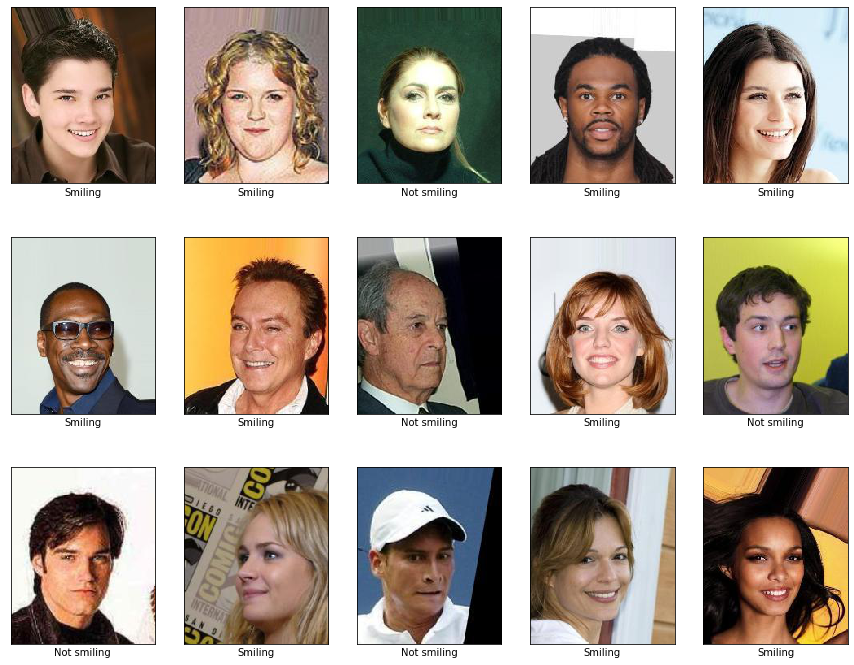

In [22]:
show_images(df=pd.concat([df_train, df_test, df_validation]), height=218, width=178, figsize=(15,12))

**Ejemplos de las imágenes una vez hecho el reshape:**

Found 15 validated image filenames belonging to 2 classes.


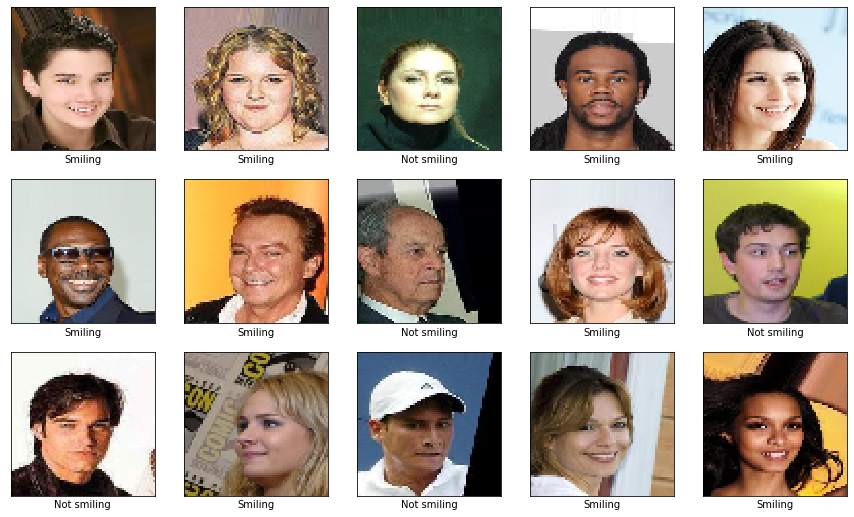

In [23]:
show_images(df=pd.concat([df_train, df_test, df_validation]))

# Experiments

## Multi Layer Perceptron (MLP)

### Image Generator

In [23]:
# Obtenemos el gerador para cada conjunto de datos
MLP_train_generator = get_generator(df_train)
MLP_test_generator = get_generator(df_test)
MLP_validation_generator = get_generator(df_validation)

Found 81385 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.


### Models

Para que esta red pueda entrenar necesitaremos pasarle una lista de arrays donde cada array represente una imagen. Para ello, transformamos la estructura tridimensional del array de numpy (obtenido al leer las imagenes) en unidimencional por medio de una primer capa (Flatten).

Como función de activacion en la capa de salida optamos por "sigmoid" debido a que se trata de una clasificacion binaria que nos indicará la probabilidad de que un imput (imagen) este sonriendo (smiling = 1). Por este mismo motivo, utilizaremos una función de pérdida del tipo "binary_crossentropy".

En cuanto a la métrica, nos basaremos en "accuracy" debido a que, como pudimos ver en la distribución del target, el dataset se encuentra balanceado.

Por último, decidimos empezar por 10 epocas para analizar una primera tendencia con cada configuracion y luego aumentarlo si es necesario.

El resto de hiperparametros los fuimos modificando experimento a experimento, pero sin llegar a una configuración que se destaque significativamente del resto. Algunas de las pruebas fueron las siguientes:

* 3 capas ocultas de 16 neuronas cada capa, con activacion "relu" y optimizador "adam" *(1)*
* 3 capas ocultas de 16 neuronas cada capa, con activacion "tanh" y optimizador "adam" *(2)*
* 3 capas ocultas de 16 neuronas cada capa, con activacion "relu" y optimizador "sgd" *(3)*
* 3 capas ocultas de 16 neuronas cada capa, con activacion "tanh" y optimizador "sgd" *(4)*
* 4 capas ocultas de 64, 32, 16 y 8 neuronas en cada capa, con activacion "relu", optimizador "adam" y un Dropout(0.1) luego de las capas 2, 3 y 4 *(5)*
* 4 capas ocultas de 64, 32, 16 y 8 neuronas en cada capa, con activacion "tanh", optimizador "adam" y un Dropout(0.1) luego de las capas 2, 3 y 4 *(6)*
* 4 capas ocultas de 64, 32, 16 y 8 neuronas en cada capa, con activacion "relu", optimizador "sgd" y un Dropout(0.1) luego de las capas 2, 3 y 4 *(7)*
* 4 capas ocultas de 64, 32, 16 y 8 neuronas en cada capa, con activacion "tanh", optimizador "sgd" y un Dropout(0.1) luego de las capas 2, 3 y 4 *(8)*

En ninguno de los casos fue posible superar el 90% de accuracy (para ninguno de los conjuntos de datos). Ademas, en la mayoria de las configuraciones obtuvimos metricas cercanas entre sí, que van desde los 84% al 90% (en accuracy).

En algunas configuraciones las metricas fueron inferiores, como por ejemplo cuando probamos con 4 capas ocultas de 64, 32, 16 y 8 neuronas respectivamente, con activacion "tanh", optimizador "adam" y un Dropout(0.1) luego de las capas 2, 3 y 4. Con esta config la red no lograba aprender nada, arrojando siempre "sonríe" independientemente de la imagen. Para este caso el accuracy fue de 48% aproximadamente, correspondiente al balanceo del target. Con otras configs probadas tambien obtuvimos fenómenos similares a este (el modelo siempre arrojaba "sonríe" o "no sonríe").

Por ello, como trabajo futuro plantearimos la necesidad de hacer nuevos experimentos, aumentando el número de neuronas en capas ocultas siempre prestando atención a los problemas relacionados con overfiting, variando a su vez, funciones de activación y optimización.

### MLP model's  final configuration

Con base en la matriz de confusión y las metricas obtenidas, elegimos como config final el siguiente modelo *(3)* porque es el que mas balanceado esta con respecto a accuracy, precision, recall y f1 score. Sin embargo, cabe aclarar que modelos como *5* y *7* arrojaban resultados muy similares y podrían haber sido seleccionados sin problema.

Decidimos incrementar las epocas a 15 como prueba final para tratar de conseguir valores mas altos en las metricas.

In [24]:
MLP_model = Sequential([
    Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    
    Dense(16, activation='relu'),
    
    Dense(16, activation='relu'),
    
    Dense(16, activation='relu'),
    
    Dense(1, activation='sigmoid')
])

MLP_model.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [25]:
MLP_train_generator.reset()
MLP_test_generator.reset()

MLP_history = MLP_model.fit_generator(MLP_train_generator, 
              epochs=15,
              workers=4,
              validation_data=MLP_test_generator
)

Epoch 1/15
2544/2544 [==============================] - 257s 101ms/step - loss: 0.5695 - accuracy: 0.6773 - val_loss: 0.2490 - val_accuracy: 0.8671
Epoch 2/15
2544/2544 [==============================] - 72s 28ms/step - loss: 0.3248 - accuracy: 0.8635 - val_loss: 0.2433 - val_accuracy: 0.8812ra
Epoch 3/15
2544/2544 [==============================] - 76s 30ms/step - loss: 0.2935 - accuracy: 0.8795 - val_loss: 0.2308 - val_accuracy: 0.8870
Epoch 4/15
2544/2544 [==============================] - 73s 29ms/step - loss: 0.2827 - accuracy: 0.8838 - val_loss: 0.2575 - val_accuracy: 0.8887
Epoch 5/15
2544/2544 [==============================] - 73s 29ms/step - loss: 0.2743 - accuracy: 0.8875 - val_loss: 0.3250 - val_accuracy: 0.8877
Epoch 6/15
2544/2544 [==============================] - 72s 28ms/step - loss: 0.2693 - accuracy: 0.8908 - val_loss: 0.3091 - val_accuracy: 0.8748
Epoch 7/15
2544/2544 [==============================] - 72s 28ms/step - loss: 0.2664 - accuracy: 0.8895 - val_loss: 0.28

### Final metrics

624/624 [==============================] - 64s 102ms/step


,Accuracy,Precision,Recall,F1
Train,0.906973,0.912216,0.892273,0.902134
Test,0.899733,0.905910,0.884399,0.895025
Validation,0.897706,0.907144,0.886252,0.896576


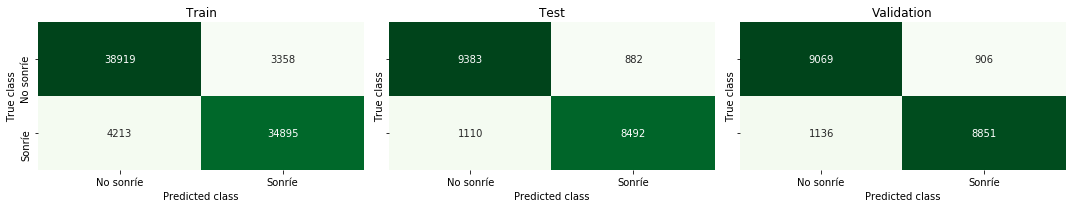

In [26]:
MLP_train_generator.reset()
MLP_test_generator.reset()
MLP_validation_generator.reset()

generators = [("Train", MLP_train_generator),
              ("Test", MLP_test_generator),
              ("Validation", MLP_validation_generator)]

evaluate_model(MLP_model, generators)

### Learning curve

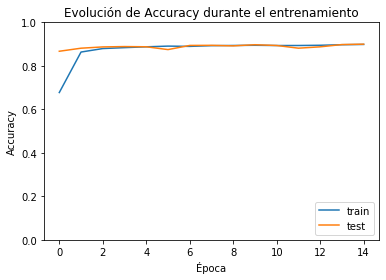

In [27]:
plot_learning_curve(MLP_history)

### Validation examples predictions

Algunos ejemplos de las predicciones realizadas por el "mejor modelo" de MLP, usando los datos de validation, son los siguientes. De cada uno se muestra la clase predicha, la probabilidad arrojada y la clase real. En cuanto a la probabilidad de que la persona sonría es necesario aclarar que si es mayor al 50% corresponde a *Smiling* y si es menor que ese porcentaje a *Not Smiling*.

**Predicciones correctas:**

Found 9981 validated image filenames belonging to 2 classes.



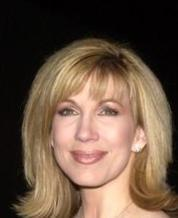
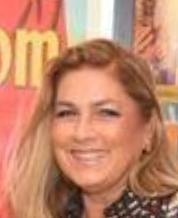
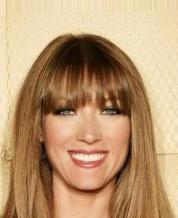
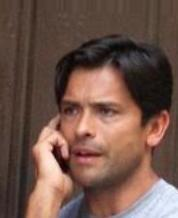
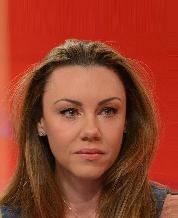
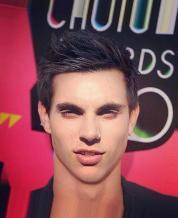
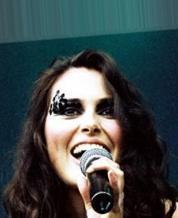
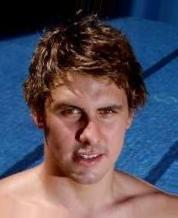
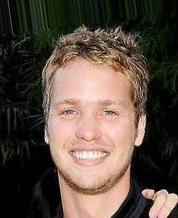
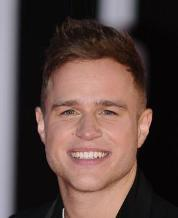
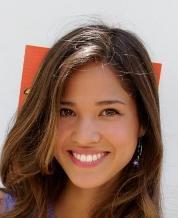
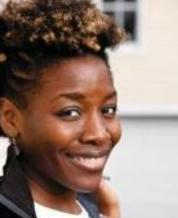
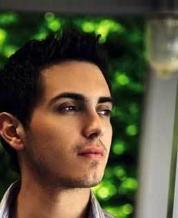
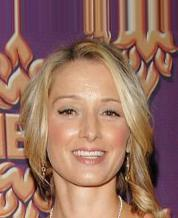
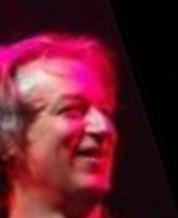
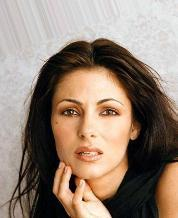

In [28]:
get_predict_samples(df_validation,MLP_model,corret_prediction=True)

**Predicciones incorrectas:**

Found 9981 validated image filenames belonging to 2 classes.



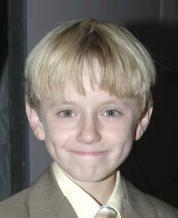
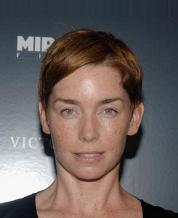
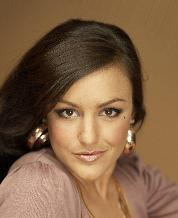
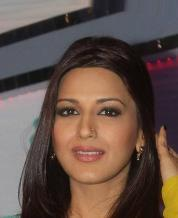
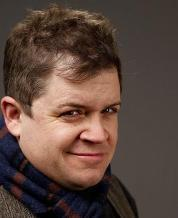
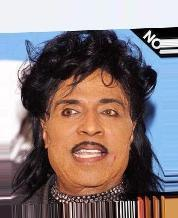
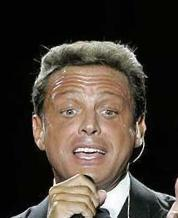
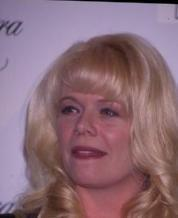
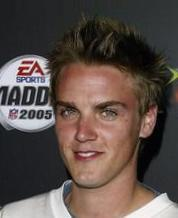
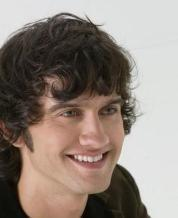
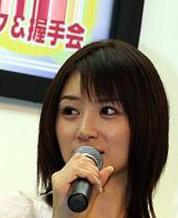
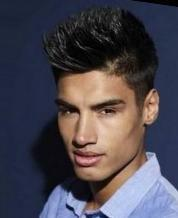
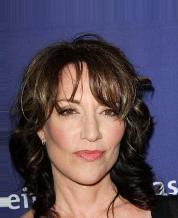
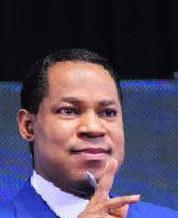
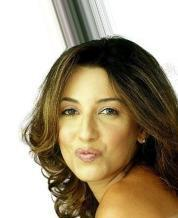
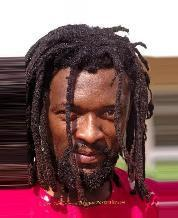

In [29]:
get_predict_samples(df_validation,MLP_model,corret_prediction=False)

# CNN

### Image Generator

In [14]:
# Obtenemos el gerador para cada conjunto de datos
CNN_train_generator = get_generator(df_train)
CNN_test_generator = get_generator(df_test)
CNN_validation_generator = get_generator(df_validation)

Found 81385 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.


### Models

Al igual que con MLP, elegimos "sigmoid" como función de activación en la capa de salida, y "binary_crossentropy" como función de pérdida. En cuanto a la métrica, seguiremos basándonos en "accuracy".

Decidimos empezar por 7 epocas para analizar una primera tendencia con cada configuracion y luego aumentarlo si es necesario.

El resto de hiperparametros los fuimos modificando experimento a experimento, pero sin llegar a una configuración que se destaque del resto. En todos los casos probados obteniamos valores cercanos al 90% en trest, pero en train se llegaba a escalar hasta un 99%.  

Se hicieron pruebas con las mismas arquitecturas, cambiando las funciones de activación o el optimizador (un cambio por vez). Además probamos con mas capas, mas filtros por capa, cambiando el tamaño del filtro, etc. En muchos casos, al ver que los valores de las métricas se estancaban, no dejamos que finalice el entrenamiento debido al elevado tiempo que esto llevaba.

Además, probamos variando los hiperparametros de la red densa que se encuentra al final, pero nada de todo eso nos permitio alcanzar metricas mas allá del 0.91 o 0.92 en test.

### CNN model's final configuration

Podríamos haber seleccionado varias configuraciones teniendo en cuenta lo dicho anteriormente, pero nos inclinamos a la siguiente porque era una de las que menos tiempo demoraba por época, logrando aún así buenos resultados finales.

In [19]:
#Definición de la arquitectura de la red convolucional
CNN_model = Sequential([
    Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    
    Conv2D(16,kernel_size=(3,3),activation='relu'),
    Dropout(0.1),
    
    Conv2D(8,kernel_size=(3,3),activation='relu'),
    Dropout(0.1),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    
    Dense(128, activation='relu'),
    Dropout(0.1),
    
    Dense(128, activation='relu'),
    Dropout(0.1),
    
    Dense(1, activation='sigmoid')
])

In [20]:
CNN_model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [17]:
CNN_train_generator.reset()
CNN_test_generator.reset()

CNN_history = CNN_model.fit(CNN_train_generator, 
              epochs=7,
              workers=4, 
              validation_data=CNN_test_generator
)

Epoch 1/7
2544/2544 [==============================] - 1456s 572ms/step - loss: 0.2726 - accuracy: 0.8809 - val_loss: 0.3875 - val_accuracy: 0.9081
Epoch 2/7
2544/2544 [==============================] - 1307s 514ms/step - loss: 0.2109 - accuracy: 0.9116 - val_loss: 0.4244 - val_accuracy: 0.9181
Epoch 3/7
2544/2544 [==============================] - 1303s 512ms/step - loss: 0.1835 - accuracy: 0.9219 - val_loss: 0.2854 - val_accuracy: 0.9129
Epoch 4/7
2544/2544 [==============================] - 1302s 512ms/step - loss: 0.1517 - accuracy: 0.9365 - val_loss: 0.4461 - val_accuracy: 0.9111
Epoch 5/7
2544/2544 [==============================] - 1303s 512ms/step - loss: 0.1110 - accuracy: 0.9549 - val_loss: 0.5583 - val_accuracy: 0.9040
Epoch 6/7
2544/2544 [==============================] - 1298s 510ms/step - loss: 0.0788 - accuracy: 0.9686 - val_loss: 0.4498 - val_accuracy: 0.9008
Epoch 7/7
2544/2544 [==============================] - 1303s 512ms/step - loss: 0.0560 - accuracy: 0.9785 - val_

En función de los resultados observados durante el entrenamiento tomaríamos la determinación de quedarnos con el modelo fiteado hasta la segunda epoca, debido a que es cuando mejor scorea este en validation (test). Una vez pasado este punto, el modelo sigue ajustando sus parámetros en train, callendo levemente el accuracy alcanzado en el set de datos de testeo. Eso último se debe a que la red es capaz de aprender mejor "los grises" (imágenes con cierto grado de relatividad a la hora de ser clasificadas (probabilidades de 0.40-0.60)) en el conjunto de datos de entrenamiento, pero no asi sus pares de test (ya que estos "grises" de test son diferentes a los mencionados anteriormente).

**Con bases en lo dicho realizamos el ree-entrenamiento del modelo:**

*Anotación: es necesario volver a ejecutar la definicion de la arquitectura y su compilación para llevar a cabo esto.*

In [21]:
CNN_train_generator.reset()
CNN_test_generator.reset()

CNN_history = CNN_model.fit(CNN_train_generator, 
              epochs=2,
              workers=4, 
              validation_data=CNN_test_generator
)

Epoch 1/2
2544/2544 [==============================] - 1395s 548ms/step - loss: 0.2646 - accuracy: 0.8884 - val_loss: 0.3837 - val_accuracy: 0.9020
Epoch 2/2
2544/2544 [==============================] - 1226s 482ms/step - loss: 0.2065 - accuracy: 0.9144 - val_loss: 0.3900 - val_accuracy: 0.9134


### Final metrics

624/624 [==============================] - 89s 142ms/step


,Accuracy,Precision,Recall,F1
Train,0.934755,0.925325,0.940089,0.932648
Test,0.913374,0.902791,0.919808,0.911220
Validation,0.910480,0.902355,0.920697,0.911434


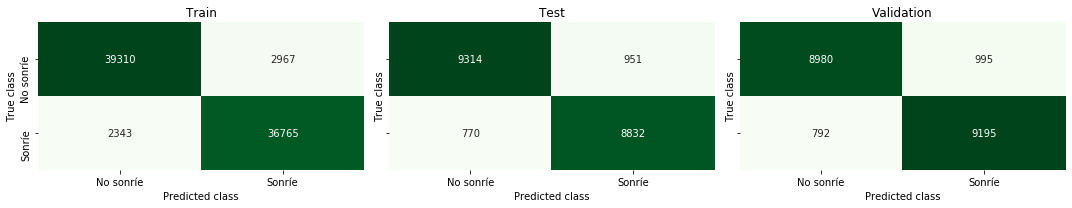

In [22]:
CNN_train_generator.reset()
CNN_test_generator.reset()
CNN_validation_generator.reset()

generators = [("Train", CNN_train_generator),
              ("Test", CNN_test_generator),
              ("Validation", CNN_validation_generator)]

evaluate_model(CNN_model, generators)

### Learning curve

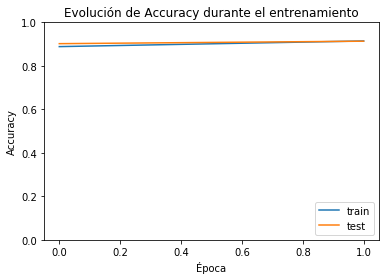

In [23]:
plot_learning_curve(CNN_history)

### Validation examples prediction

Algunos ejemplos de las predicciones realizadas por el "mejor modelo" de CNN, usando los datos de validation, son los siguientes. Al igual de como se hizo para MLP, se muestra la clase predicha, la probabilidad arrojada y la clase real para cada imagen de entrada.

**Predicciones correctas:**

Found 9981 validated image filenames belonging to 2 classes.



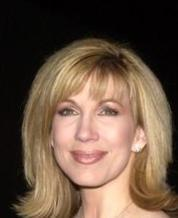
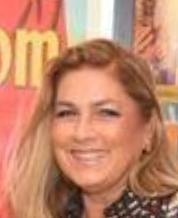
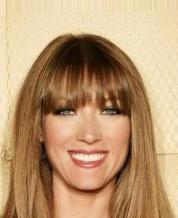
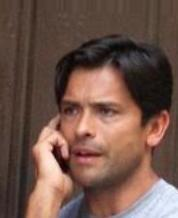
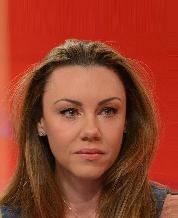
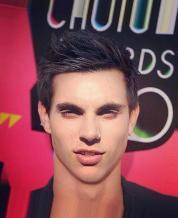
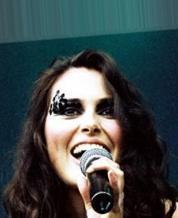
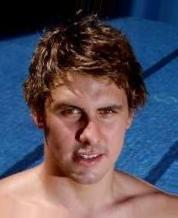
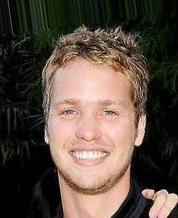
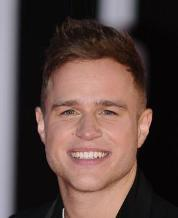
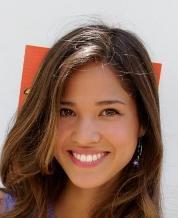
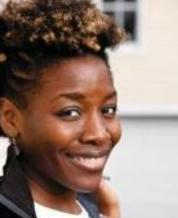
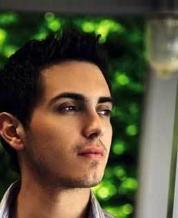
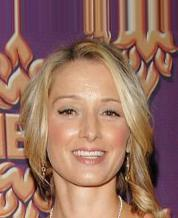
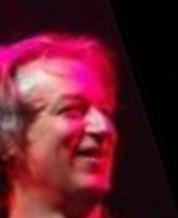
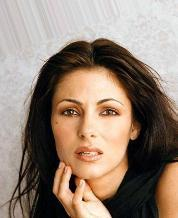

In [24]:
get_predict_samples(df_validation,CNN_model,corret_prediction=True)

**Predicciones incorrectas:**

Found 9981 validated image filenames belonging to 2 classes.



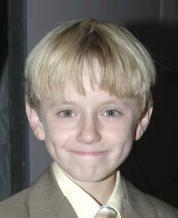
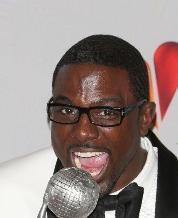
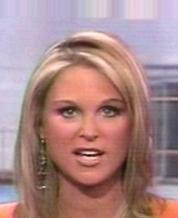
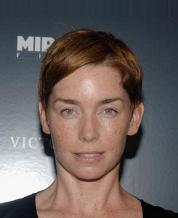
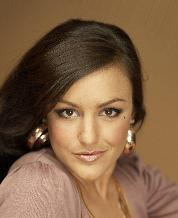
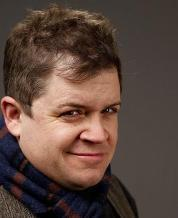
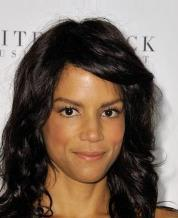
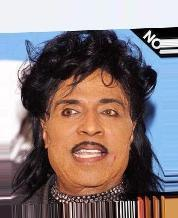
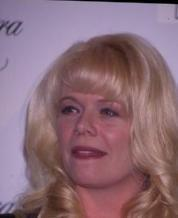
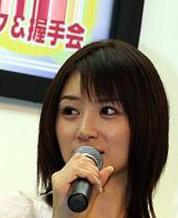
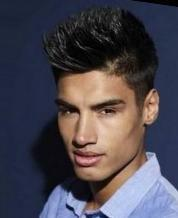
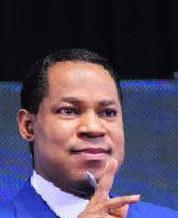
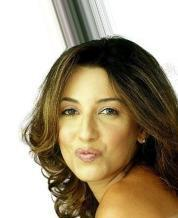
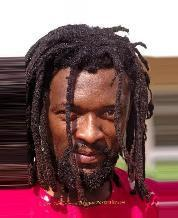
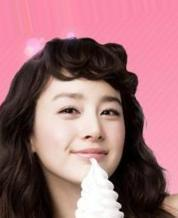
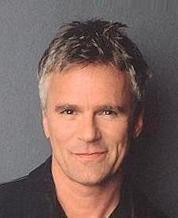

In [25]:
get_predict_samples(df_validation,CNN_model,corret_prediction=False)

## Conclusions

Como se puede observar en los modelos entrenados, no existen demasiadas diferencias en las capacidades de clasificación. En test y validation obtuvimos métricas muy similares en accuracy, aproximadas al 90-92%. Esto quiere decir que ambos modelos son buenos clasificando ejemplos nuevos (de cada 100 ejemplos, solo 8-10 ejemplos estaran mal clasificados).

Lo mencionado anteriormente es relativo, ya que al observar los ejemplos mal clasificados podemos decir que, en su mayoría, se tratan de "grises". Es decir, ejemplos que tienen una probabilidad entre el 40% y 60% de estar sonriendo. Al aplicar una frontera de decisión en 0.5 es posible la division en clases, pero la seguridad de estar clasificando bien es baja. 

En lo que respecta a CNN este es capáz de alcanzar scores muy elevados en train, pero estancando (o incluso disminuyendo levemente) su pérformance en el conjunto de datos de testeo. Esto se debe a que, como mencionamos anteriormente, existen "grises" de difícil interpretación en el set de datos. Durante el entrenamiento, en caso de dejar muchas épocas, el modelos sobreajusta sus pesos y se "aprende estos grises", los cuales son diferentes a los grises de test (por lo que este no es capáz de clasificarlos correctamente).

Sumado a lo anterior, encontramos ejemplos que, a nuestro parecer, estarian mal clasificados originalmente, siendo la categoría "verdadera" la arrojada por el modelo.

## Future work

* Realizar un control del tageado de las imágenes haciendo foco especialmente en aquellas predicciones donde el modelo arroja probabilidades de 0.40-0.60 ("grises" de los cuales el modelo no tiene alta seguridad al momento de decidir su clasificación).

* Leer mas papers o artículos académicos que evidencien arquitecturas de red probadas y funcionales para este tipo de problemas.

* Utilizar técnicas de Data Augmentation para tratar de mejorar las predicciones del modelo sobre aquellos casos donde claramente estamos recayendo en una clasificacion errónea.

* Aplicar progressive resizing para evaluiar mejoras en la pérformance del modelo.